In [1]:
import numpy as np
import pandas as pd
import config as c
import scipy.special as special
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from datetime import timedelta, datetime, date, time
from sklearn.metrics import r2_score, mean_squared_error

from astropy.time import Time
from astropy import units as u
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Mars, Sun, Jupiter, Venus
from poliastro.plotting import OrbitPlotter3D, OrbitPlotter2D


import utils.metrics as metrics
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading
from preprocessing.preprocessing import get_sat_list

from utils.kepler_utils import kepler_numba, rv_from_elements_np, rv_from_elements
from utils.math_utils import normalize, moving_average, mean_without_k_outlies, get_angle
from utils.physical_utils import get_orbit_from_orbital_elements, get_vectors_from_orbit

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


Using TensorFlow backend.
C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (t

In [2]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

df['nu+argp'] = df['nu'] + df['argp']

real_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
sim_columns = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,delta_time,a,ecc,inc,raan,argp,nu,error,h,nu+argp
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,2803.000,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17,0.000535,26080.000000,4.188790
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,2803.000,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01,0.002533,26686.896582,4.655131
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,...,2803.001,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01,0.001743,28338.043990,5.083352
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,...,2803.000,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00,0.000915,30651.371610,5.455184
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,...,2803.001,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00,0.000948,33244.665434,5.771519


### Выделяем спутники в отдельные таблицы

In [3]:
def get_quick_predictions(index_delta, predict_df):
    quick_predictions=[]

    for sat_id in predict_df['sat_id'].unique():
        sat = df[df['sat_id']==sat_id]

        index = index_delta
        r1 = sat.iloc[index][['x', 'y', 'z']].to_numpy().astype('float64')
        v1 = sat.iloc[index][['Vx', 'Vy', 'Vz']].to_numpy().astype('float64')
        total_seconds = sat.iloc[index]['total_seconds']

        sat = predict_df[predict_df['sat_id']==sat_id]

        quick_predictions.append(np.array(sat['total_seconds'].map(
            lambda t: kepler_numba(r1, v1, t-total_seconds, numiter=100, rtol=1e-9)).to_list()))

    quick_predictions = np.concatenate(quick_predictions, axis=0)
    return quick_predictions


df[sim_columns] = pd.DataFrame(get_quick_predictions(0, df), columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])
sat_list = get_sat_list(df)

C:\Users\79105\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Определение периода обращения

In [4]:
def get_mean_anomaly(a, e, t0, t1):
    bad_gap = (t1>np.pi) * (t0<np.pi)
    
    b = a*np.sqrt(1-e**2)
    
    E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t0/2))
    E1 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t1/2))
    
    M0 = E0-e*np.sin(E0)
    M1 = E1-e*np.sin(E1)
    M2 = bad_gap * np.pi * 2
    
    s = M1 - M0 + M2
    return s

In [ ]:
fig, axs = plt.subplots(150, figsize = (30, 450), sharex=True, sharey=True)

for i in range(150):
    sat = sat_list[i]['d']
    
    a = sat[['x', 'y', 'z']].to_numpy()
    b = sat[['x', 'y', 'z']].shift(-1).to_numpy()
    delta_t = np.arccos(np.sum(a * b, axis=1) / (np.sqrt(np.sum(a**2, axis=1)) * np.sqrt(np.sum(b**2, axis=1))))
    sat['delta_t'] = delta_t

    sat['area'] = abs(get_mean_anomaly(sat.a, sat.ecc, sat.nu, sat.nu+sat.delta_t))
    
    d=sat
    main_part = d[['area']][:len(d)//24*24].to_numpy().reshape((-1, 24, 1))
    averaged_values = np.apply_along_axis(mean_without_k_outlies, 1, main_part)
    
    y = (d.delta_time.iloc[0] / averaged_values)[:-1]
    y = y/y.mean()-1
    x = np.linspace(0,len(y),num=len(y))
    
    
    axs[i].set_title('subplot '+str(i))
    axs[i].plot(x[:-1], y[:-1], '-bx')
    
    x = np.linspace(0,n,num=len(sat['ecc']))
    axs[i].plot(x,normalize(sat['ecc'], 0.01), 'r')

plt.show()

## Предсказание изменения параметров орбиты

- Большая полуось - g.
- Эксцентриситет - r.
- Наклонение - b.
- Долгота восходящего узла - cyan.
- Аргумент перицентра - k.
- Истинная аномалия - y.

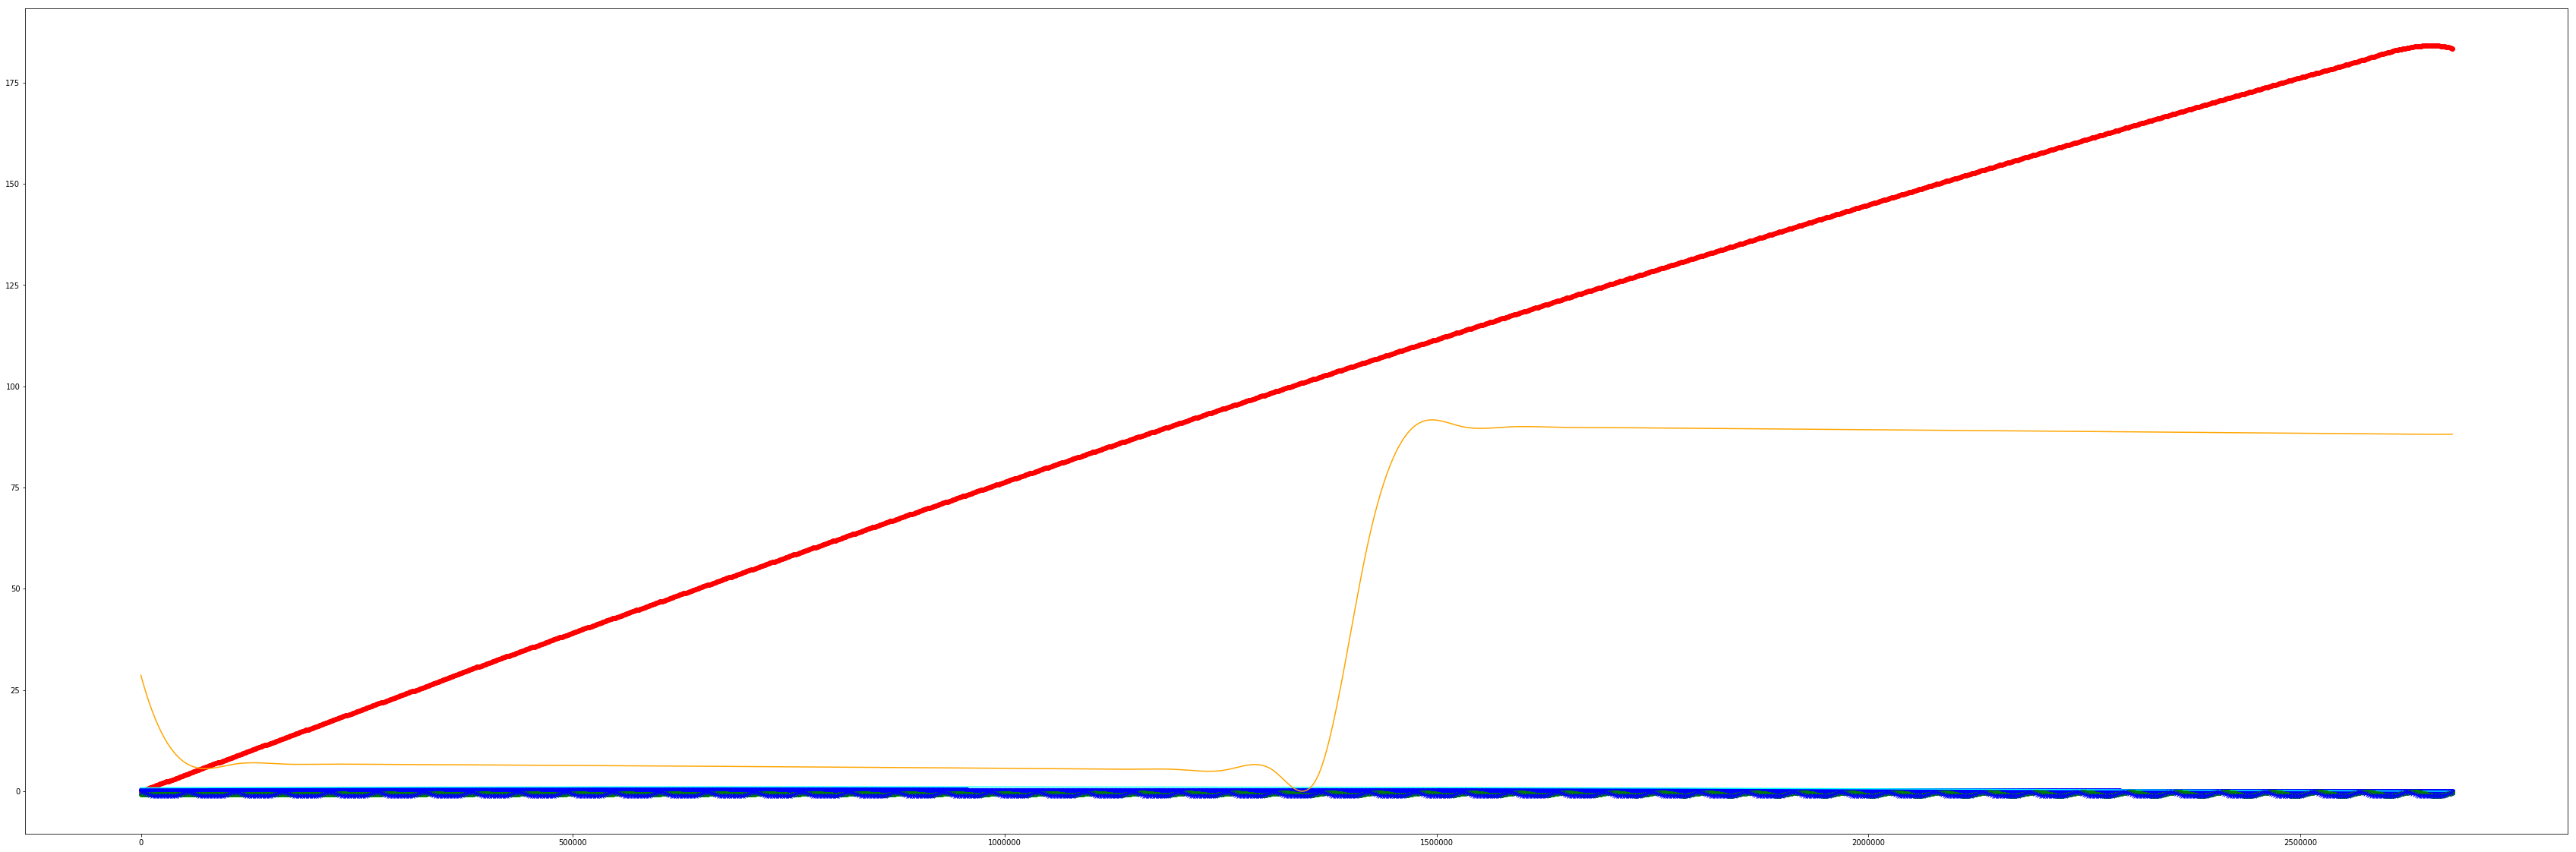

In [103]:
d = sat_list[225]['d']

plt.figure(figsize = (60, 20))
k = 100

x = d['total_seconds']

y = d['a']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-go')

y = d['ecc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-ro')

y = d['inc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-bo')

y = d['raan']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, 'cyan')

y = d['argp']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, 'orange')


y = d['nu']
y=y/y.mean()-1
y*=k
y=y-y.min()
#plt.plot(x,y, 'orange')


y=(d.x**2 + d.y**2 + d.z**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-go')

y=(d.x_sim**2 + d.y_sim**2 + d.z_sim**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-bx')

plt.show()

## Линейное предсказание параметров орбиты

In [5]:
df_test = pd.read_csv("data/test.csv")
df_test['epoch'] = df_test.epoch.map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
df_test['total_seconds'] = df_test.epoch.map(lambda x: (x - datetime(2014, 1, 1)).total_seconds())
df_test.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds
0,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,2678505.162
1,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,2679777.007
2,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,2681048.852
3,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,2682320.697
4,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,2683592.542


In [104]:
def get_next_rv_nu(p, delta_time):
    rv = rv_from_elements(p[0], p[1], p[2], p[3], p[4], p[5])
    r0 = rv[0]

    rv = kepler_numba(rv[0], rv[1], delta_time, numiter=100, rtol=1e-9)
    r1 = rv[:3]

    nu = get_angle(r0, r1)
    #print(delta_time)
    return rv, nu

class LinearRegressionModel:
    def __init__(self):
        self.reg = None
        
    def get_x(self, data):
        pd.options.mode.chained_assignment = None
        data.loc[:,'total_seconds_square'] = data['total_seconds']**1.1
        return np.array(data[['total_seconds', 'total_seconds_square']])
    
    def fit(self, data):
        x = self.get_x(data)
        y = data[['a', 'ecc', 'inc', 'raan', 'argp']]
        
        self.reg = LinearRegression().fit(x, y)
        
        p = np.array(data[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']].iloc[0])
        positions = self.step_by_step_predict(data, p, 0)
        
        # Ошибка в определении времени
        self.delta_time_list = []
        for a, e, t1, t0 in zip(data['a'], data['ecc'], data['nu'], self.nu_list):
            mean_anomaly = get_mean_anomaly(a, e, t0, t1)
            if (mean_anomaly < -4):
                mean_anomaly+=np.pi*2
            elif (mean_anomaly > 4):
                mean_anomaly-=np.pi*2
                

            delta_t = mean_anomaly# / sqrt(c.mu / a**3)
            self.delta_time_list.append(delta_t)
        
        return positions
    
    def predict(self, row, p):
        if p[1]>0.9:
            return p
        p = self.reg.predict([row])[0]
        return np.append(p, 0)
    
    def test(self, data):              
        border = len(data)//2
        d = data.iloc[:border]
        self.fit(d)
        
        original_smape = metrics.smape(np.array(d[sim_columns]),
                                       np.array(d[real_columns]))
        

        p_time = d['total_seconds'].iloc[-1]
        p = np.array(d[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']])[-1]
        d = data.iloc[border:]
        
        positions = self.step_by_step_predict(d, p, p_time)
        self.positions_self = positions
        
        model_smape = metrics.smape(positions, d[real_columns].to_numpy())
        
        return (1-original_smape)*100, (1-model_smape)*100, (original_smape/model_smape)
    
    def step_by_step_predict(self, d, p, p_time):        
        positions = []
        self.nu_list = []
        
        X = self.get_x(d)
        for x in X:
            rv, nu = get_next_rv_nu(p, x[0]-p_time)
            positions.append(rv)
            p_time = x[0]
            nu += p[-1]
            
            self.nu_list.append(nu)
            p = self.predict(x, p)
            p[-1] = nu
        positions = np.array(positions)
        
        return positions
        

model = LinearRegressionModel()
model.test(sat_list[225]['d'])

(87.40721034738783, 73.92528072774908, 0.48295015264128205)

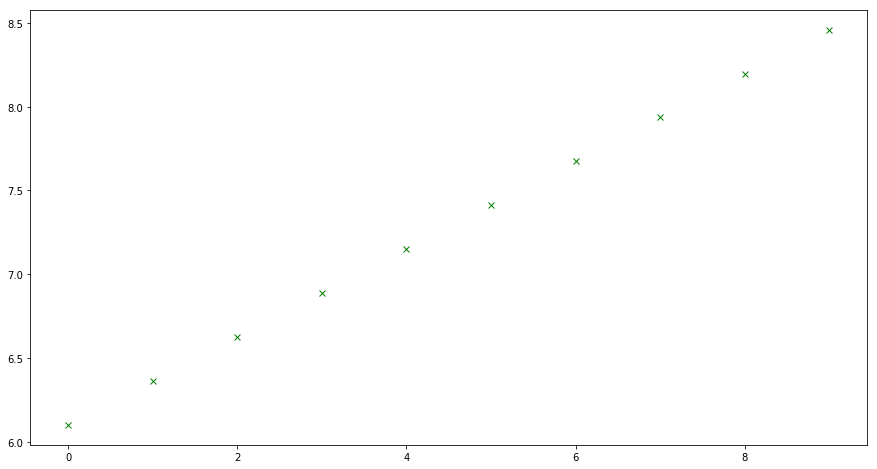

In [105]:
d = sat_list[225]['d']
positions = model.fit(d)

plt.figure(figsize = (15, 8))
plt.plot(model.nu_list[:10], 'gx')
plt.show()

In [106]:
sat_id = 225
d = sat_list[sat_id]['d']

model = LinearRegressionModel()
model.test(d)

p = np.array(d.iloc[-1,17:23])
p_time = d.iloc[-1,15]

test_d = df_test[df_test['sat_id']==sat_id]

test = model.step_by_step_predict(test_d, p, p_time)

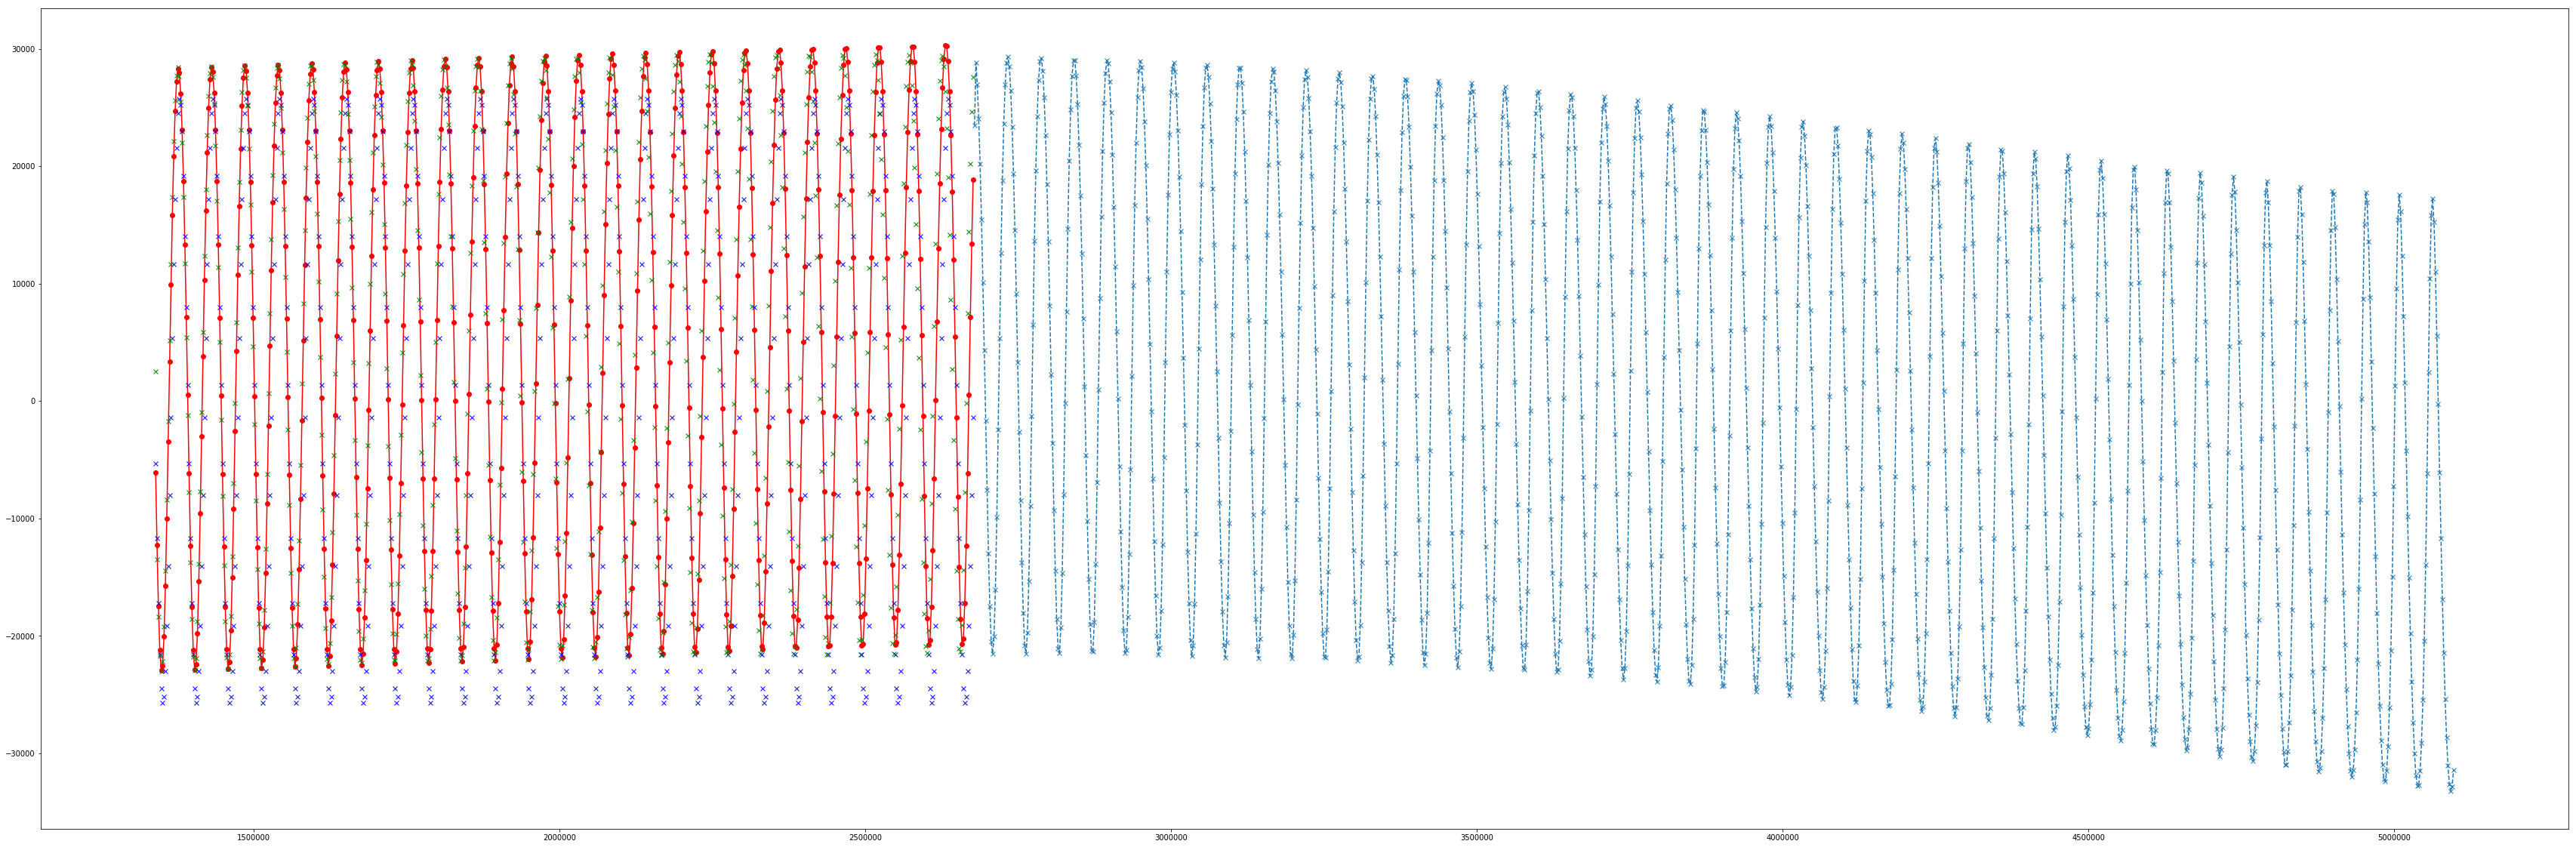

In [107]:
plt.figure(figsize = (60, 20))

d = sat_list[sat_id]['d']
border = len(d)//2

x = d.iloc[border:,15]

plt.plot(x, np.array(d.iloc[border:]['x']), '-ro')
plt.plot(x, np.array(d.iloc[border:]['x_sim']), 'bx')
plt.plot(x, model.positions_self[:,0], 'gx')

x = test_d['total_seconds']
plt.plot(x, test[:,0], '--x')
    
plt.show()

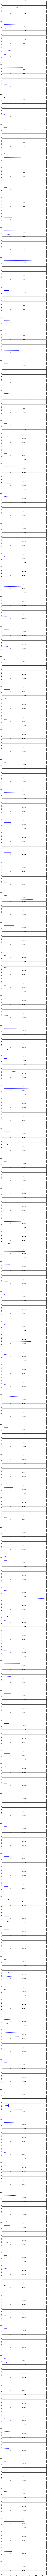

In [23]:
fig, axs = plt.subplots(600, figsize = (15, 900), sharex=True, sharey=True)

for i in range(600):
    d = sat_list[i]['d']

    model = LinearRegressionModel()
    positions = model.fit(d)    
    
    x = np.linspace(0,len(model.delta_time_list),num=len(model.delta_time_list))
    
    axs[i].set_title('subplot '+str(i))
    axs[i].plot(x, model.delta_time_list, '-b')

plt.show()

In [15]:
r_list=[]
len_list=[]

for i in range(600):
    d = sat_list[i]['d']
    model = LinearRegressionModel()
    r = model.test(d)[2]
    
    r_list.append(r)
    len_list.append(len(d))

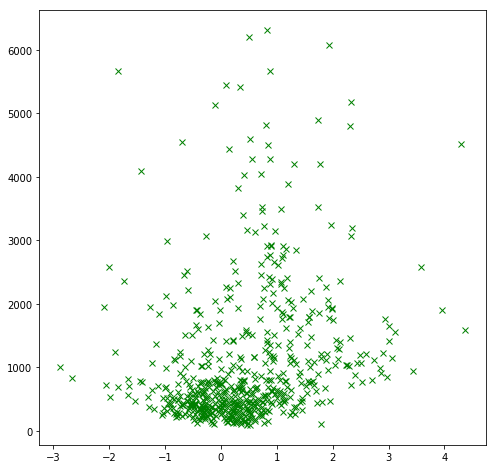

In [16]:
plt.figure(figsize = (8, 8))

plt.plot(np.log(r_list),len_list, 'gx')
    
plt.show()

In [17]:
predictions=[]

for sat_id in df_test['sat_id'].unique():
    d = sat_list[sat_id]['d']

    index = -1
    r1 = d.iloc[index][['x', 'y', 'z']].to_numpy().astype('float64')
    v1 = d.iloc[index][['Vx', 'Vy', 'Vz']].to_numpy().astype('float64')
    total_seconds = d.iloc[index]['total_seconds']

    sat = df_test[df_test['sat_id']==sat_id]

    quick_prediction = np.array(sat['total_seconds'].map(
        lambda t: kepler_numba(r1, v1, t-total_seconds, numiter=100, rtol=1e-9)).to_list())
    
    model = LinearRegressionModel()
    
    if model.test(d)[2] > 0.95:
        model.fit(d)
        p = np.array(d.iloc[-1,17:23])
        p_time = d.iloc[-1,15]

        predictions.append(model.step_by_step_predict(sat, p, p_time))
    else:
        predictions.append(quick_prediction)

predictions = np.concatenate(predictions, axis=0)


df_test[sim_columns] = pd.DataFrame(predictions, columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])

In [18]:
submission = pd.read_csv("data/submission.csv")

submission[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=df_test[sim_columns]
submission.to_csv("data/output_submission.csv",index=False,sep=',')